In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def calculate_eddy(width=500000, num_depth_layers=21, eta0=1, L=1e5, H=1000, a=1, b=1, rho0=1025, 
                                            f0=None, alpha_1=0., alpha_2=0., T0=20, dTdz=0.005, dSdz=0.01, taper_depth=None):
    """
    Calculate the 3D geostrophic velocity components U, V, density anomaly sigma, temperature, salinity, 
    and pressure fields for an ocean eddy.

    Parameters:
    - width: Horizontal extent of the grid (eddy scale) in meters.
    - num_depth_layers: Number of vertical layers (depth resolution).
    - eta0: Surface elevation perturbation.
    - L: Horizontal length scale of the eddy in meters.
    - H: Vertical depth scale of the eddy in meters.
    - a, b: Coefficients affecting density anomaly variation.
    - rho0: Reference density (kg/m^3).
    - f0: Coriolis parameter. If None, it will be calculated based on a latitude of -34 degrees.
    - alpha_1, alpha_2: Coefficients affecting eddy center shift with depth.
    - T0: Surface temperature (degrees Celsius).
    - dTdz: Temperature gradient with depth (degrees Celsius per meter).
    - dSdz: Salinity gradient with depth (psu per meter).
    - taper_depth: Tapering scale for vertical variations.

    Returns:
    - U, V: 3D matrices for the U and V (x- and y-components) velocity fields.
    - sigma: 3D matrix for the density anomaly.
    - T: 3D matrix for the temperature field.
    - S: 3D matrix for the salinity field.
    - P: 3D matrix for the pressure field.
    - x, y, z: Horizontal and vertical grid points.
    """
    # Constants
    if f0 is None:
        f0 = 2 * 7.29E-5 * np.sin(np.radians(-34))  # Coriolis parameter for latitude -34 degrees
    g = 9.81  # Gravitational acceleration (m/s^2)
    # Create 2D meshgrid for horizontal space (x, y) and depth (z)
    x = np.linspace(-width // 2, width // 2, 101)  # x-coordinates
    y = np.linspace(-width // 2, width // 2, 101)  # y-coordinates
    z = np.linspace(-H, 0, num_depth_layers)  # Depth levels from surface (0) to -H
    # Create 3D meshgrid
    x_3d, y_3d, z_3d = np.meshgrid(x, y, z, indexing='ij')
    if taper_depth is None:
        taper_factor = np.ones_like(z_3d)
    else:
        taper_factor = np.exp(z_3d / taper_depth)
    # Define the functions f(|r - r_c(z)|) and g(z)
    def f_r_rc(r, L):
        return np.exp(-r**2 / L**2)
    # Calculate the center position as a function of depth
    x_c = alpha_1 * z_3d
    y_c = alpha_2 * z_3d
    # Calculate radial distance r - r_c(z)
    r_c = np.hypot( x_3d - x_c, y_3d - y_c )
    # Temperature field
    # T = T0 + dTdz * z_3d - 2 * f_r_rc(r_c, L) * taper_factor
    T = - 2 * f_r_rc(r_c, L) * taper_factor
    # Salinity field
    S0 = 35  # Reference surface salinity (psu)
    # S = S0 + dSdz * z_3d + 1.5 * f_r_rc(r_c, L) * taper_factor
    S = 1.5 * f_r_rc(r_c, L) * taper_factor
    # Pressure field (hydrostatic pressure)
    P = -rho0 * g * z_3d
    # Density field using a simplified equation of state
    alpha = 0.0002  # Thermal expansion coefficient (1/°C)
    beta = 0.0008  # Haline contraction coefficient (1/psu)
    sigma = rho0 * (1 - alpha * (T - T0) + beta * (S - S0)) 
    sigma -= np.mean(sigma)
    # Calculate geostrophic velocity components
    dx = x[1] - x[0]  # Grid spacing in x
    dy = y[1] - y[0]  # Grid spacing in y
    d_sigma_dx = np.gradient(sigma, axis=0) / dx
    d_sigma_dy = np.gradient(sigma, axis=1) / dy
    U = g / f0 * d_sigma_dy * taper_factor
    V = -g / f0 * d_sigma_dx * taper_factor

    U = np.flip(U, axis=2)
    V = np.flip(V, axis=2)
    sigma = np.flip(sigma, axis=2)
    T = np.flip(T, axis=2)
    S = np.flip(S, axis=2)
    P = np.flip(P, axis=2)
    z = np.flip(z)

    return U, V, sigma, T, S, P, x, y, z

In [3]:
def nencioli(u, v, lon, lat, a, b): #,var
    """
    Returns:
    - eddy_uv: Positions that satisfy the first two constraints (for debugging)
    - eddy_c: Positions satisfying the first three constraints (for debugging)
    - eddy: Positions of the eddy centers with their type (cyclonic=1, anticyclonic=-1)
    """
    borders = max(a, b) + 1
    # Compute velocity magnitude
    vel = np.sqrt(u**2 + v**2)
    # Initialize arrays for storing eddy centers
    eddy_uv = np.zeros((0, 2))
    eddy_c = np.zeros((0, 2))
    eddy = np.zeros((0, 3))
    # Get domain dimensions
    bound = vel.shape
    # Loop through each latitudinal section
    for i in range(borders, len(v) - borders + 1):
        wrk = v[i, :]  # Latitudinal section of v
        # First constraint: zero crossing in v component
        s = np.sign(wrk)
        indx = np.where(np.diff(s) != 0)[0]
        indx = indx[(indx >= borders) & (indx < len(wrk) - borders)]
        for ii in indx:
            var = 0  # Eddy type (0 = no eddy, 1 = cyclonic, -1 = anticyclonic)
            if wrk[ii] >= 0:  # Anticyclonic
                if wrk[ii - a] > wrk[ii] and wrk[ii + 1 + a] < wrk[ii + 1]:
                    var = -1
            elif wrk[ii] < 0:  # Cyclonic
                if wrk[ii - a] < wrk[ii] and wrk[ii + 1 + a] > wrk[ii + 1]:
                    var = 1
            # Second constraint: u component reversal
            if var != 0:
                if var == -1:
                    if (u[i - a, ii] <= 0 and u[i - a, ii] <= u[i - 1, ii] and
                        u[i + a, ii] >= 0 and u[i + a, ii] >= u[i + 1, ii]):
                        eddy_uv = np.vstack([eddy_uv, [lat[i, ii], lon[i, ii]], [lat[i, ii + 1], lon[i, ii + 1]]])
                    else:
                        var = 0
                elif var == 1:
                    if (u[i - a, ii] >= 0 and u[i - a, ii] >= u[i - 1, ii] and
                        u[i + a, ii] <= 0 and u[i + a, ii] <= u[i + 1, ii]):
                        eddy_uv = np.vstack([eddy_uv, [lat[i, ii], lon[i, ii]], [lat[i, ii + 1], lon[i, ii + 1]]])
                    else:
                        var = 0
                # Third constraint: velocity minimum
                if var != 0:
                    srch = vel[i - b:i + b, ii - b:ii + b + 1]
                    slat = lat[i - b:i + b, ii - b:ii + b + 1]
                    slon = lon[i - b:i + b, ii - b:ii + b + 1]
                    X, Y = np.unravel_index(np.argmin(srch), srch.shape)
                    srch2 = vel[max(i - b + X - 1 - b, 0):min(i - b + X - 1 + b, bound[0]),
                                max(ii - b + Y - 1 - b, 0):min(ii - b + Y - 1 + b, bound[1])]

                    if np.min(srch2) == np.min(srch):
                        eddy_c = np.vstack([eddy_c, [slat[X, Y], slon[X, Y]]])
                    else:
                        var = 0
                # Fourth constraint: vector rotation (simplified version)
                d = a - 1
                if var != 0:
                    # Find indices of the estimated center in the large domain
                    i1, i2 = np.where((lat == slat[X, Y]) & (lon == slon[X, Y]))
                    i1, i2 = int(i1[0]), int(i2[0])
                    # Extract velocities within "a-1" points from the estimated center
                    u_small = u[max(i1 - d, 0):min(i1 + d, bound[0]), max(i2 - d, 0):min(i2 + d, bound[1])]
                    v_small = v[max(i1 - d, 0):min(i1 + d, bound[0]), max(i2 - d, 0):min(i2 + d, bound[1])]
                    # Apply constraint only if there are no NaNs in u_small
                    if not np.isnan(u_small).any():
                        # Boundary velocities
                        u_bound = np.concatenate([u_small[0, :], u_small[1:, -1], u_small[-1, -2::-1], u_small[-2::-1, 0]])
                        v_bound = np.concatenate([v_small[0, :], v_small[1:, -1], v_small[-1, -2::-1], v_small[-2::-1, 0]])
                        # Vector defining which quadrant each boundary vector belongs to
                        quadrants = np.zeros_like(u_bound)
                        quadrants[(u_bound >= 0) & (v_bound >= 0)] = 1
                        quadrants[(u_bound < 0) & (v_bound >= 0)] = 2
                        quadrants[(u_bound < 0) & (v_bound < 0)] = 3
                        quadrants[(u_bound >= 0) & (v_bound < 0)] = 4
                        # Identify the first fourth quadrant vector
                        spin = np.where(quadrants == 4)[0]
                        # Apply the constraint only if the rotation is complete and not all vectors are in the fourth quadrant
                        if spin.size > 0 and spin.size != quadrants.size:
                            # If vectors start in the 4th quadrant, add 4 to all quadrant positions after the first occurrence
                            if spin[0] == 0:
                                spin = np.where(quadrants != 4)[0]
                                spin = spin[0] - 1
                            if not isinstance(spin, np.ndarray):
                                spin = np.array([int(spin)])
                            quadrants[spin[-1] + 1:] += 4
                            # Inspect vector rotation: no consecutive vectors should be more than one quadrant apart
                            # and there should be no backward rotation
                            if not np.any(np.diff(quadrants) > 1) and not np.any(np.diff(quadrants) < 0):
                                eddy = np.vstack([eddy, [slat[X, Y], slon[X, Y], var]])
    # Process eddy results (sorting and removing duplicates)
    eddy = np.unique(eddy, axis=0)
    eddy_uv = np.unique(eddy_uv, axis=0)
    eddy_c = np.unique(eddy_c, axis=0)
    # Adjust for the Southern Hemisphere (flip cyclonic/anticyclonic labels)
    eddy[:, 2] = -eddy[:, 2]

    return eddy_uv, eddy_c, eddy

In [4]:
U, V, sigma, T, S, P, x, y, z = calculate_eddy(taper_depth=None)

U_tap, V_tap, sigma_tap, T_tap, S_tap, P_tap, _, _, _ = calculate_eddy(taper_depth=400)

dx, dy, dz = x[1] - x[0], y[1] - y[0], z[1]-z[0]

alpha_1 = dx / dz # tilt in x direction

U_tilt, V_tilt, sigma_tilt, T_tilt, S_tilt, P_tilt, _, _, _ = calculate_eddy(taper_depth=None, alpha_1=alpha_1)

U_tilt_tap, V_tilt_tap, sigma_tilt_tap, T_tilt_tap, S_tilt_tap, P_tilt_tap, _, _, _ = calculate_eddy(taper_depth=400, alpha_1=alpha_1)

In [5]:
modelled_data = {
    'Eddy0':{
        'Name': 'E1', 'U': U, 'V': V, 'sigma': sigma, 'T': T, 'S': S, 'P': P
    },
    'Eddy1':{
        'Name': r'E1$_\text{tap}$', 'U': U_tap, 'V': V_tap, 'sigma': sigma_tap, 'T': T_tap, 'S': S_tap, 'P': P_tap
    },
    'Eddy2':{
        'Name': 'E2', 'U': U_tilt, 'V': V_tilt, 'sigma': sigma_tilt, 'T': T_tilt, 'S': S_tilt, 'P': P_tilt
    },
    'Eddy3':{
        'Name': r'E2$_\text{tap}$', 'U': U_tilt_tap, 'V': V_tilt_tap, 'sigma': sigma_tilt_tap, 'T': T_tilt_tap, 'S': S_tilt_tap, 'P': P_tilt_tap
    },
    'x': x, 'y': y, 'z': z
}
eddies = ['Eddy0', 'Eddy1', 'Eddy2', 'Eddy3']

In [6]:
def find_root(x, y):
    coefficients = np.polyfit(x, y, 3)
    polynomial = np.poly1d(coefficients)
    roots = np.roots(polynomial)
    R = np.abs(x[len(x)//2] - roots)
    root = roots[np.argmin(R)]

    return root

def tang_at_root(x, y, root_x):
    coeffs = np.polyfit(x, y, 3)
    poly_derivative = np.polyder(coeffs)
    slope_at_root = np.polyval(poly_derivative, root_x)
    y_at_root = np.polyval(coeffs, root_x)
    intercept = y_at_root - slope_at_root * root_x
    
    return slope_at_root, intercept

def moca2_mod(nic, njc, u, v, X, Y, r=5):
    u1, v1 = u[nic-r:nic+r+1, njc], v[nic-r:nic+r+1, njc]
    x1, y1 = X.T[nic-r:nic+r+1, njc], Y.T[nic-r:nic+r+1, njc]
    xx = x1 - X.T[nic, njc]

    u2, v2 = u[nic, njc-r:njc+r+1], v[nic, njc-r:njc+r+1]
    x2, y2 = X.T[nic, njc-r:njc+r+1], Y.T[nic, njc-r:njc+r+1]
    yy = y2 - Y.T[nic, njc]

    root_x = find_root(xx, v1)
    A1, A0 = tang_at_root(xx, u1, root_x)
    B1, B0 = tang_at_root(xx, v1, root_x)
    
    root_y = find_root(yy, u2)
    C1, C0 = tang_at_root(yy, u2, root_y)
    D1, D0 = tang_at_root(yy, v2, root_y)
    
    r2A = np.inf if np.min(np.abs(u1)) == 0 else 1 / np.min(np.abs(u1))
    r2B = np.inf if np.min(np.abs(v1)) == 0 else 1 / np.min(np.abs(v1))
    r2C = np.inf if np.min(np.abs(u2)) == 0 else 1 / np.min(np.abs(u2))
    r2D = np.inf if np.min(np.abs(v2)) == 0 else 1 / np.min(np.abs(v2))

    alpha = A0 if r2A > r2C else C0
    beta = B0 if r2B > r2D else D0
    gamma = A1 if r2A > r2D else -D1
    q11, q12, q22 = B1 / 2, -gamma / 2, -C1 / 2

    x0 = - ( alpha*gamma + beta*C1  ) / (C1*B1+gamma**2)
    y0 = ( beta*gamma-alpha*B1  ) / (C1*B1+gamma**2)
    w = 2 * (q11 + q22)

    return x0 + X.T[nic, njc], y0 + Y.T[nic, njc], w, x1, y1, u1, v1, x2, y2, u2, v2, xx, yy

In [7]:
result_data = pd.DataFrame(columns=['Eddy', 'z', 'nic', 'njc', 'nxc', 'nyc', 'xc', 'yc', 'Depth', 'Vort'])

x, y = modelled_data['x']/1000, modelled_data['y']/1000
dx = x[1] - x[0]
X, Y = np.meshgrid(x, y)
var = 1
plot_data = {}

for eddy in eddies:

    plot_data[eddy] = {}
    U, V = modelled_data[eddy]['U'], modelled_data[eddy]['V']
    xc_pre, yc_pre = 0, 0

    for depth_lvl in range(U.shape[-1]):

        # Find nencioli
        u, v = U[:, :, depth_lvl], V[:, :, depth_lvl]
        neddy = nencioli(u.T, v.T, X, Y, 4, 3)[2]
        neddy = neddy[neddy[:, 2] == var]
        
        if len(neddy[:, 1]) > 1:
            R = np.hypot(xc_pre - neddy[:, 1], yc_pre - neddy[:, 0])
            neddy = neddy[R == np.nanmin(R)]
        elif len(neddy[:, 1]) == 0:
            break
        
        nxc, nyc = neddy[0, 1], neddy[0, 0]
        nic, njc = np.where(nxc == x)[0][0], np.where(nyc == y)[0][0]

        xc, yc, w, x1, y1, u1, v1, x2, y2, u2, v2, xx, yy = moca2_mod(nic, njc, u, v, X, Y)

        # VORT_THRESH = 0.006
        R = np.hypot(xc - xc_pre, yc - yc_pre)
        # if np.abs(w) > VORT_THRESH and R < 100:
        if R < 100:
            result_data.loc[len(result_data)] = {
                'Eddy': eddy,
                'z': depth_lvl,
                'nic': nic,
                'njc': njc,
                'nxc': nxc,
                'nyc': nyc,
                'xc': xc,
                'yc': yc,
                'Depth': z[depth_lvl],
                'Vort': w,
            }
            xc_pre, yc_pre = xc, yc
            plot_data[eddy][f'xx{depth_lvl}'] = xx
            plot_data[eddy][f'yy{depth_lvl}'] = yy
            
            plot_data[eddy][f'x1_{depth_lvl}'] = x1
            plot_data[eddy][f'y1_{depth_lvl}'] = y1
            plot_data[eddy][f'x2_{depth_lvl}'] = x2
            plot_data[eddy][f'y2_{depth_lvl}'] = y2
            
            plot_data[eddy][f'u1_{depth_lvl}'] = u1
            plot_data[eddy][f'u2_{depth_lvl}'] = u2
            plot_data[eddy][f'v1_{depth_lvl}'] = v1
            plot_data[eddy][f'v2_{depth_lvl}'] = v2
        else:
            break

In [8]:
result_data

,Eddy,z,nic,njc,nxc,nyc,xc,yc,Depth,Vort
0,Eddy0,0,50,50,0.0,0.0,0.0,5.916376e-16,0.0,-0.078690
1,Eddy0,1,50,50,0.0,0.0,0.0,5.916376e-16,-50.0,-0.078690
2,Eddy0,2,50,50,0.0,0.0,0.0,5.916376e-16,-100.0,-0.078690
3,Eddy0,3,50,50,0.0,0.0,0.0,5.916376e-16,-150.0,-0.078690
4,Eddy0,4,50,50,0.0,0.0,0.0,5.916376e-16,-200.0,-0.078690
...,...,...,...,...,...,...,...,...,...,...
79,Eddy3,16,66,50,80.0,0.0,80.0,3.321995e-16,-800.0,-0.001441
80,Eddy3,17,67,50,85.0,0.0,85.0,-2.373365e-16,-850.0,-0.001122
81,Eddy3,18,68,50,90.0,0.0,90.0,1.933074e-16,-900.0,-0.000874
82,Eddy3,19,69,50,95.0,0.0,95.0,2.948222e-16,-950.0,-0.000681


In [9]:
eddy = 'Eddy1'

df = result_data[result_data['Eddy'] == eddy].drop(columns='Eddy').set_index('z')
df

,nic,njc,nxc,nyc,xc,yc,Depth,Vort
z,,,,,,,,
0,50,50,0.0,0.0,0.0,5.916376e-16,0.0,-0.078690
1,50,50,0.0,0.0,0.0,3.857817e-16,-50.0,-0.061284
2,50,50,0.0,0.0,0.0,4.262885e-16,-100.0,-0.047728
3,50,50,0.0,0.0,0.0,-1.323575e-16,-150.0,-0.037170
4,50,50,0.0,0.0,0.0,1.722959e-16,-200.0,-0.028948
5,50,50,0.0,0.0,0.0,4.517740e-16,-250.0,-0.022545
6,50,50,0.0,0.0,0.0,2.460985e-18,-300.0,-0.017558
7,50,50,0.0,0.0,0.0,-4.062815e-18,-350.0,-0.013674
8,50,50,0.0,0.0,0.0,-4.447286e-16,-400.0,-0.010649


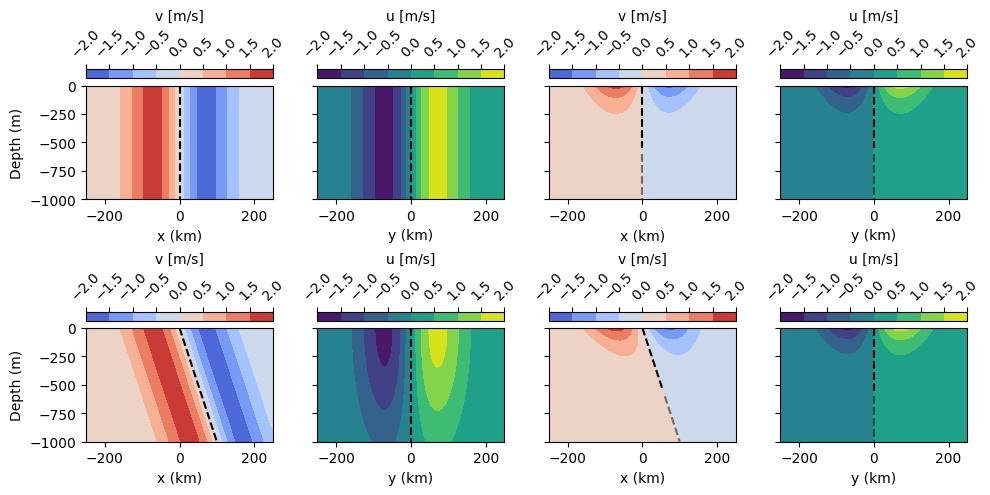

In [10]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5), sharey=True)
x = modelled_data['x']/1000
y = modelled_data['y']/1000
for i, ax_pair in enumerate(axs.reshape(-1, 2)):
    eddy = eddies[i]
    U = modelled_data[eddy]['U'][modelled_data[eddy]['U'].shape[0] // 2, :, :]
    V = modelled_data[eddy]['V'][:, modelled_data[eddy]['V'].shape[1] // 2, :]

    im1 = ax_pair[0].contourf(x, z, V.T, cmap='coolwarm')
    im2 = ax_pair[1].contourf(y, z, U.T)

    df = result_data[result_data['Eddy'] == eddy].drop(columns='Eddy').set_index('z')

    VORT_THRESH = -0.006
    mask = df['Vort'] <= VORT_THRESH
    mask = mask.tolist()
    for i in range(len(mask) - 2, -1, -1):
        if mask[i] and not mask[i + 1]:
            mask[i + 1] = True
            break
    mask = pd.Series(mask)
    ax_pair[0].plot(df.loc[mask, 'xc'], df.loc[mask, 'Depth'], 'k', label='VG', alpha=1, linestyle='--')
    ax_pair[0].plot(df.loc[~mask, 'xc'], df.loc[~mask, 'Depth'], 'k', alpha=0.5, linestyle='--')
    ax_pair[1].plot(df.loc[mask, 'yc'], df.loc[mask, 'Depth'], 'k', label='VG', alpha=1, linestyle='--')
    ax_pair[1].plot(df.loc[~mask, 'yc'], df.loc[~mask, 'Depth'], 'k', alpha=0.5, linestyle='--')
        
    ax_pair[0].set_xlabel('x (km)')
    ax_pair[1].set_xlabel('y (km)')

    cbar1 = fig.colorbar(im1, ax=ax_pair[0], orientation='horizontal', location='top', label='v [m/s]')
    cbar2 = fig.colorbar(im2, ax=ax_pair[1], orientation='horizontal', location='top', label='u [m/s]')

    # Rotate colorbar ticks
    cbar1.ax.tick_params(axis='x', rotation=45)
    cbar2.ax.tick_params(axis='x', rotation=45)

axs[0, 0].set_ylabel('Depth (m)')
axs[1, 0].set_ylabel('Depth (m)')

plt.tight_layout()
plt.show()


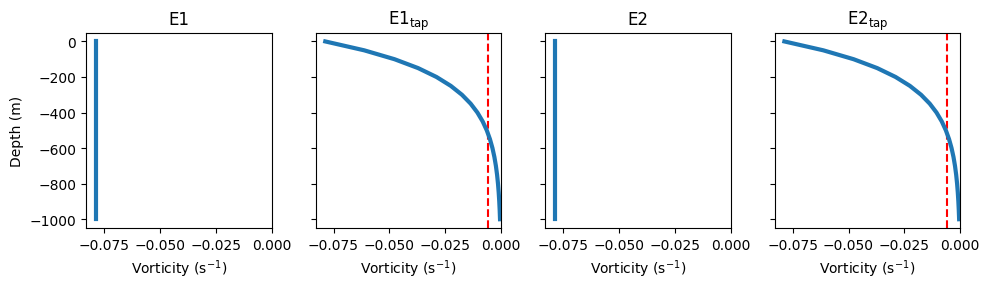

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(10, 3), sharey=True)
xmin = 0
for ax, eddy in zip(axs.flatten(), eddies):
    df = result_data[result_data['Eddy'] == eddy].drop(columns='Eddy').set_index('z')
    ax.plot(df['Vort'], df['Depth'], linewidth=3)
    ax.set_title(modelled_data[eddy]['Name'])
    xmin = min(xmin, ax.get_xlim()[0])

VORT_THRESH = -0.006
axs[1].axvline(x=VORT_THRESH, color='r', linestyle='--', zorder=0) 
axs[3].axvline(x=VORT_THRESH, color='r', linestyle='--', zorder=0) 

for ax in axs.flatten():
    ax.set_xlim(xmin, 0)
    ax.set_xlabel(r'Vorticity (s$^{-1}$)')

axs[0].set_ylabel('Depth (m)')

fig.tight_layout()
plt.show()


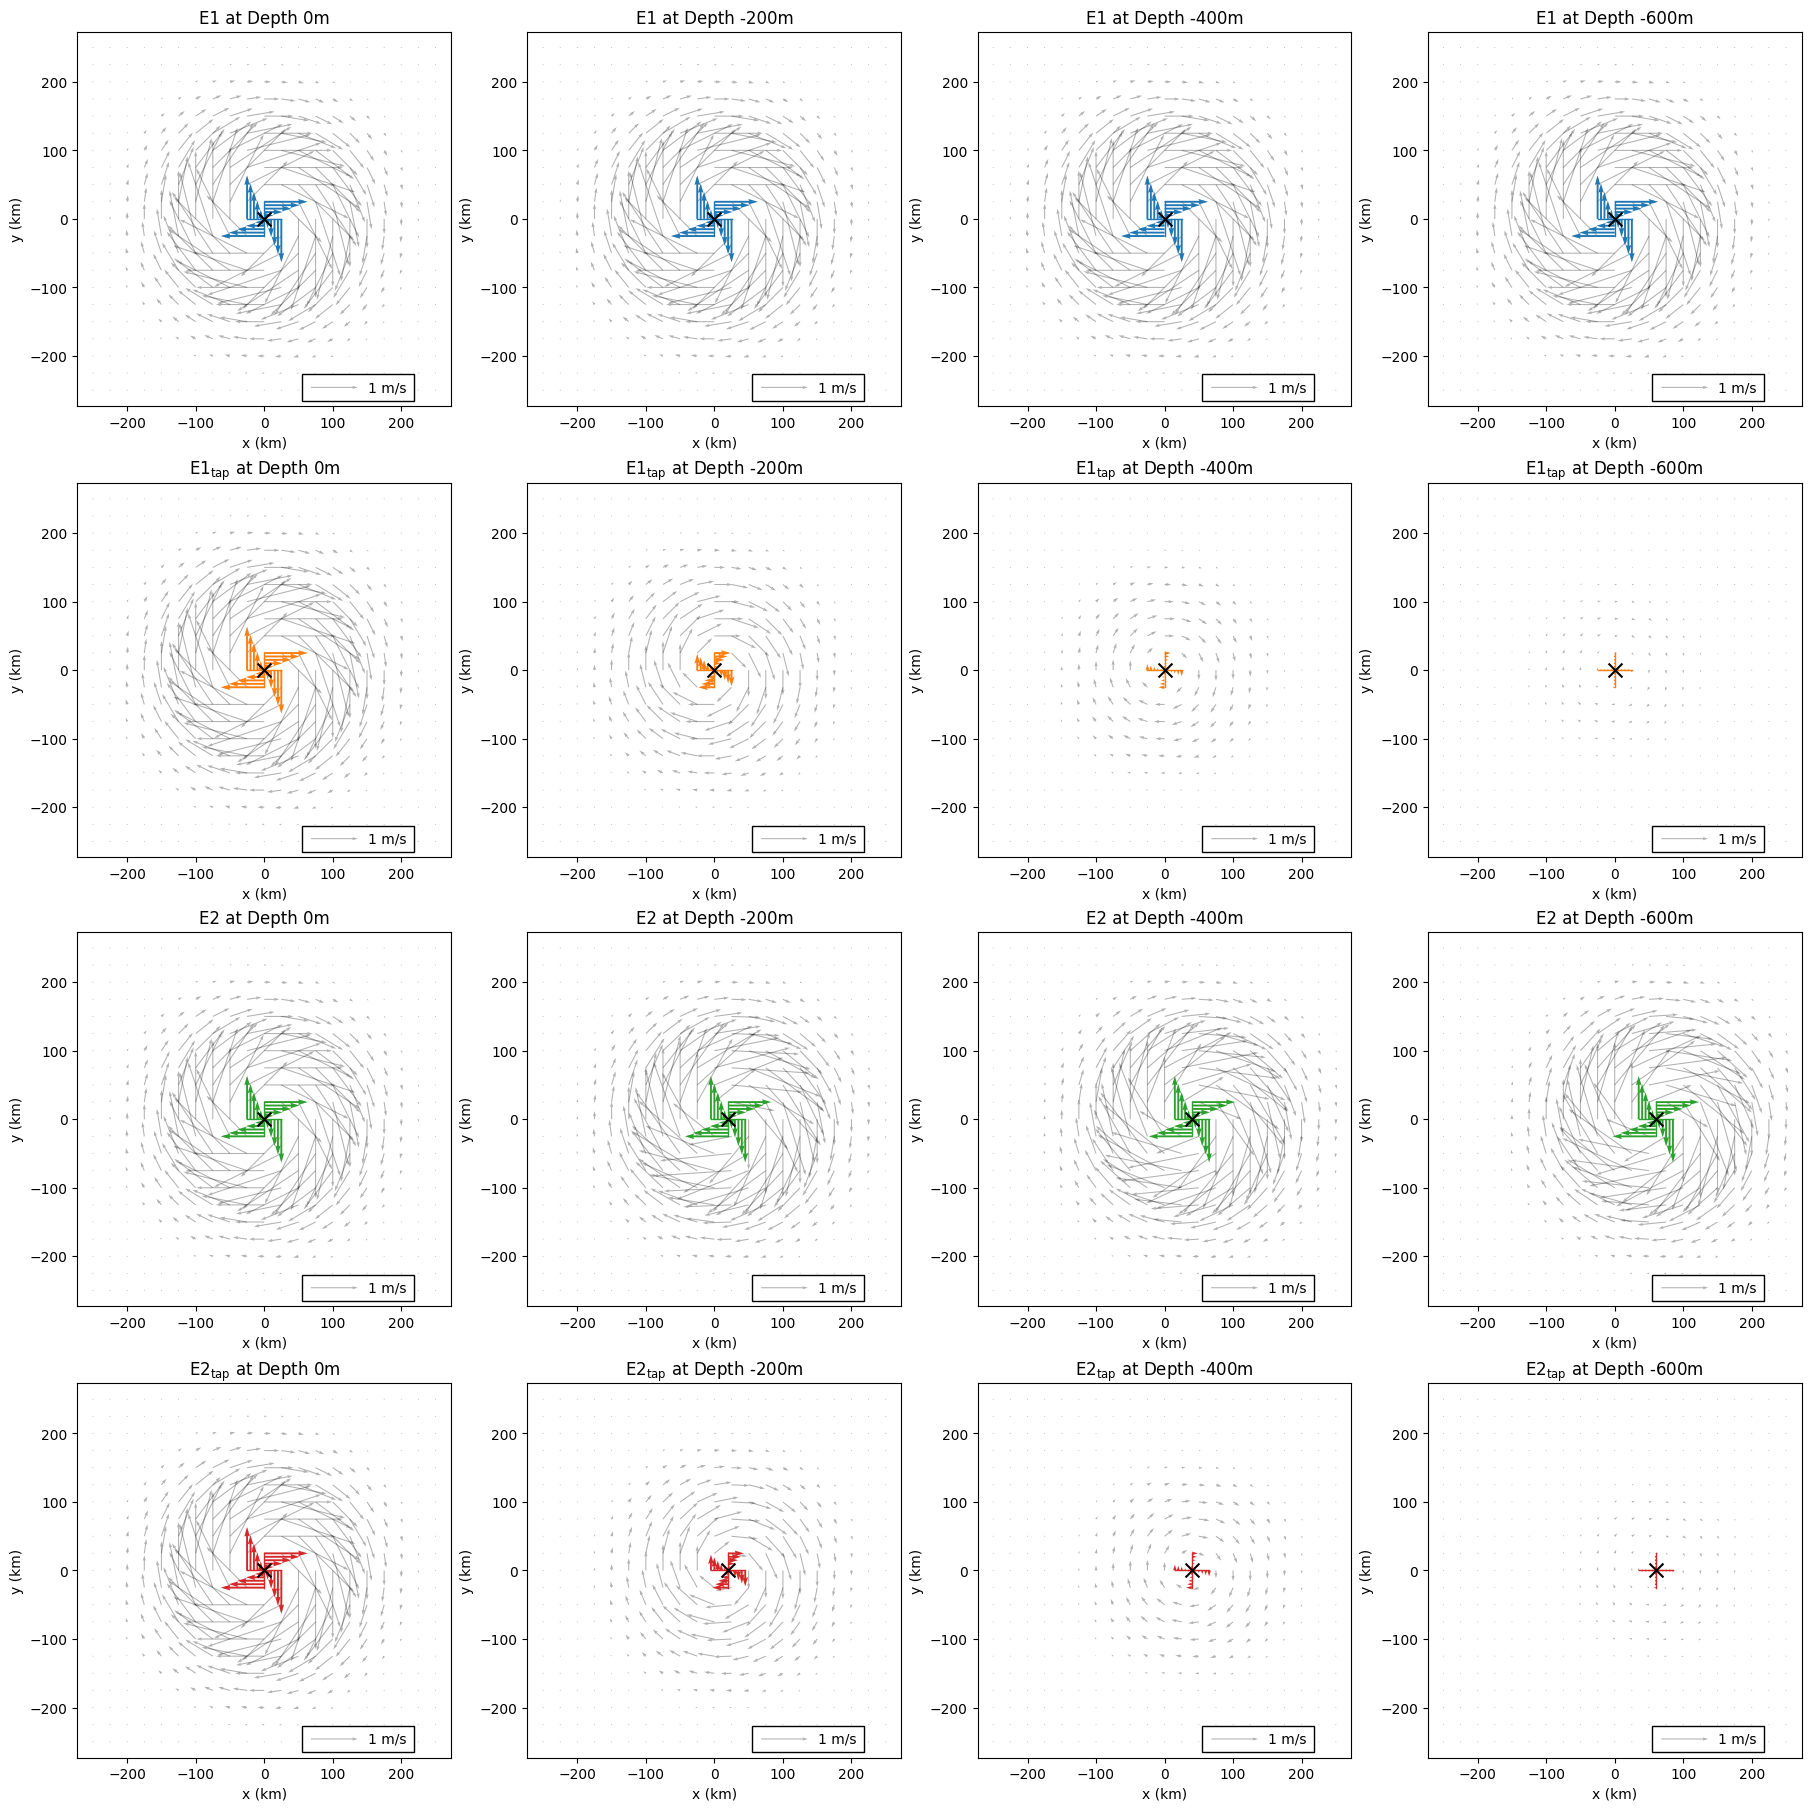

In [12]:
from matplotlib.patches import Rectangle

fig, axes = plt.subplots(4, 4, figsize=(18, 18), constrained_layout=True)#, sharex=True, sharey=True)
for r, eddy in enumerate(eddies):
    
    depth_lvls = [0, 4, 8, 12]
    
    scale_factor = [8, 8, 8, 8]
    colors = plt.cm.tab10.colors * 3

    x = modelled_data['x']/1000
    y = modelled_data['y']/1000
    z = modelled_data['z']
    X, Y = np.meshgrid(x, y)
    
    for i, depth_lvl in enumerate(depth_lvls):
        ax = axes[r, i]
        
        u = modelled_data[eddy]['U'][:, :, depth_lvl]
        v = modelled_data[eddy]['V'][:, :, depth_lvl]

        name = modelled_data[eddy]['Name']
        
        spacing = 5
        quiv = ax.quiver(X[::spacing, ::spacing], Y[::spacing, ::spacing],
                  u[::spacing, ::spacing].T, v[::spacing, ::spacing].T,
                  alpha=0.3, scale=scale_factor[i])
        data = result_data[result_data['Eddy'] == eddy].drop(columns='Eddy').set_index('z').loc[depth_lvl]  
        n_xc = data['nxc'] 
        n_yc = data['nyc']
        xc = data['xc'] 
        yc = data['yc'] 
        i_nenc = data['nic'] 
        j_nenc = data['njc'] 
        xx = plot_data[eddy]['xx'+str(depth_lvl)]
        yy = plot_data[eddy]['yy'+str(depth_lvl)]

        x1 = plot_data[eddy]['x1_'+str(depth_lvl)]
        y1 = plot_data[eddy]['y1_'+str(depth_lvl)]
        x2 = plot_data[eddy]['x2_'+str(depth_lvl)]
        y2 = plot_data[eddy]['y2_'+str(depth_lvl)]

        iu = plot_data[eddy]['u1_'+str(depth_lvl)]
        iv = plot_data[eddy]['v1_'+str(depth_lvl)]
        ju = plot_data[eddy]['u2_'+str(depth_lvl)]
        jv = plot_data[eddy]['v2_'+str(depth_lvl)]
        
        spacing = 1
        ax.quiver(x1[::spacing], y1[::spacing],
                  iu[::spacing], iv[::spacing], color=colors[r], scale=scale_factor[i], width=0.005)
        ax.quiver(x2[::spacing], y2[::spacing],
                  ju[::spacing], jv[::spacing], color=colors[r], scale=scale_factor[i], width=0.005)
        ax.plot(x1, y1, zorder=0, linewidth=1, color=colors[r])
        ax.plot(x2, y2, zorder=0, linewidth=1, color=colors[r])
        ax.scatter(xc, yc, marker='x', s=100, color='k')
        
        ax.set_xlabel('x (km)')
        ax.set_ylabel('y (km)')
        ax.set_title(name+' at Depth '+str(round(z[depth_lvl]))+'m')

        if np.any(np.isnan(u)) and r != 1:
            nan_mask = np.isnan(u)
            mask = np.where(~np.isnan(u), np.nan, 0)
            ax.contourf(x, y, mask.T, cmap='gray', zorder=-1)
            ax.contour(x, y, nan_mask.T, colors='k', linewidths=2, alpha=.5)

        magnitude = 1
        x_pos, y_pos = 0.75, 0.05  
        box_width = 0.3  # Adjust width as needed
        box_height = 0.07  # Adjust height as needed
        rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                               box_width, box_height, transform=ax.transAxes,
                               facecolor='white', edgecolor='black')
        ax.add_patch(rect)
        ax.quiverkey(quiv, X=x_pos, Y=y_pos, U=magnitude,
                     label=f'{magnitude} m/s', labelpos='E')
        ax.axis('equal')
        
plt.show()

In [20]:
def vis(eddy, depth_lvl):
    
    x, y = modelled_data['x']/1000, modelled_data['y']/1000
    dx = x[1] - x[0]
    X, Y = np.meshgrid(x, y)
    var = 1
    
    U, V = modelled_data[eddy]['U'], modelled_data[eddy]['V']
    
    # Find nencioli
    u, v = U[:, :, depth_lvl], V[:, :, depth_lvl]
    neddy = nencioli(u.T, v.T, X, Y, 4, 3)[2]
    neddy = neddy[neddy[:, 2] == var]
    
    if len(neddy[:, 1]) > 1:
        R = np.hypot(xc_pre - neddy[:, 1], yc_pre - neddy[:, 0])
        neddy = neddy[R == np.nanmin(R)]
    elif len(neddy[:, 1]) == 0:
        raise ValueError("Error: Nencioli failed to find eddy center.")
    
    nxc = neddy[0, 1] #+ 25000
    nyc = neddy[0, 0] #+ 25000
    nic, njc = np.where(nxc == x)[0][0], np.where(nyc == y)[0][0]

    xc, yc, w, x1, y1, u1, v1, x2, y2, u2, v2, xx, yy = moca2_mod(nic, njc, u, v, X, Y)

    fig, axs = plt.subplots(1, 4, figsize=(28, 7))
    datasets = [(xx, u1, 'u1'),
                (xx, v1, 'v1'),
                (yy, u2, 'u2'),
                (yy, v2, 'v2')]
    
    root_x = find_root(xx, v1)
    A1, A0 = tang_at_root(xx, u1, root_x)
    B1, B0 = tang_at_root(xx, v1, root_x)
    p_u1 = A1*xx + A0
    p_v1 = B1*xx + B0

    root_y = find_root(yy, u2)
    C1, C0 = tang_at_root(yy, u2, root_y)
    D1, D0 = tang_at_root(yy, v2, root_y)
    p_u2 = C1*yy + C0
    p_v2 = D1*yy + D0
    
    for i, (ax, (l, vel, label)) in enumerate(zip(axs, datasets)):

        if i == 0:
            ax.plot(xx, p_u1, 'b--')
        elif i == 1:
            ax.plot(xx, p_v1, 'k--',)
        elif i == 2:
            ax.plot(yy, p_u2, 'b--')
        elif i == 3:
            ax.plot(yy, p_v2, 'k--')
        
        ax.axhline(0, color='k', linestyle='-', linewidth=0.5, alpha=.5)
        ax.set_xlabel('x' if '1' in label else 'y')
        ax.set_ylabel(label)
        i += 1
    plt.tight_layout()
    plt.show()

    # Plot results
    spacing = 5
    plt.quiver(X[::spacing, ::spacing], Y[::spacing, ::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T)

    plt.plot(x1, y1, 'r', zorder=1, alpha=.5)
    plt.plot(x2, y2, 'r', zorder=1, alpha=.5)

    if np.any(np.isnan(u)):
        nan_mask = np.isnan(u)
        mask = np.where(~np.isnan(u), np.nan, 0)
        plt.contourf(X, Y, mask.T, cmap='gray', zorder=-1)
        plt.contour(X, Y, nan_mask.T, colors='k', linewidths=2, alpha=.5)

    # plt.scatter(nxc/1000, nyc/1000, color='k', marker='x', label='Nenc')
    plt.scatter(xc, yc, color='r', marker='x', s=100, label='MOCA')
    plt.legend()


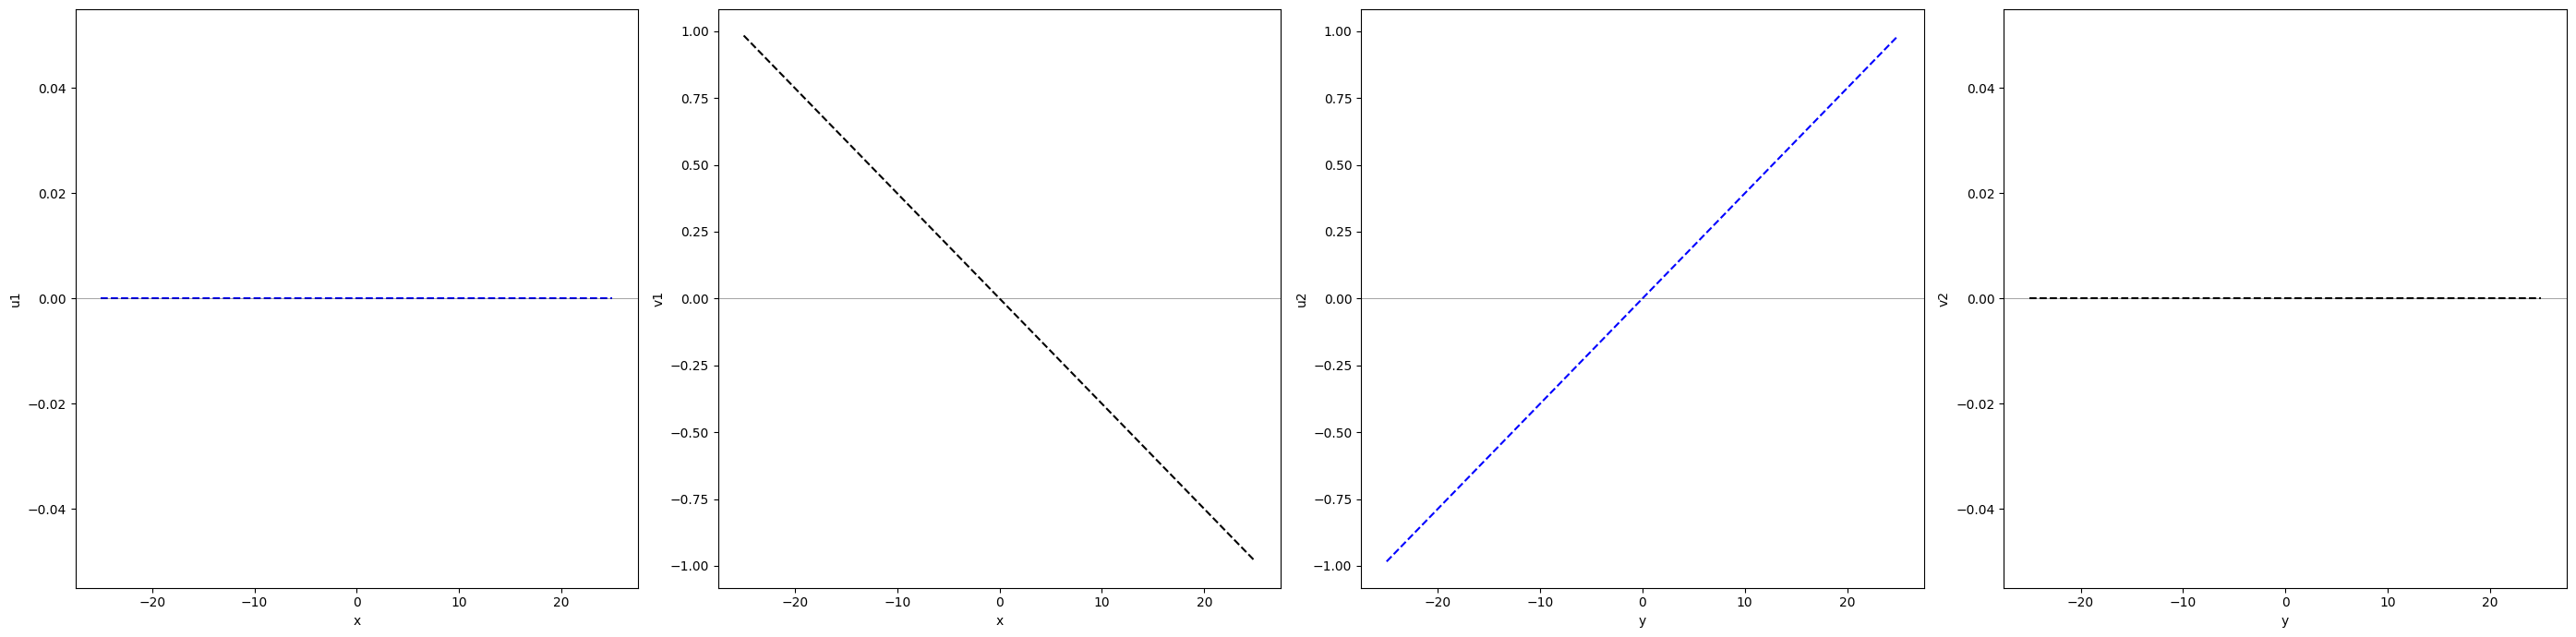

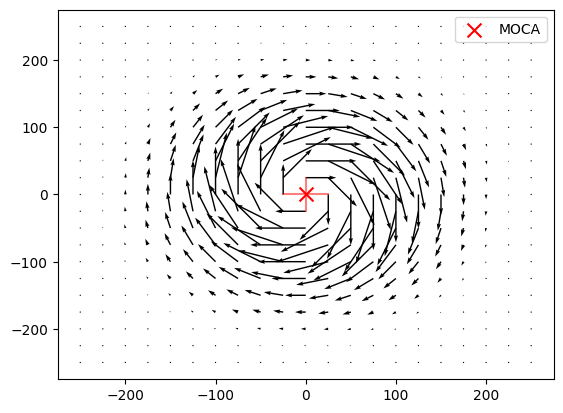

In [21]:
vis('Eddy2', 0)

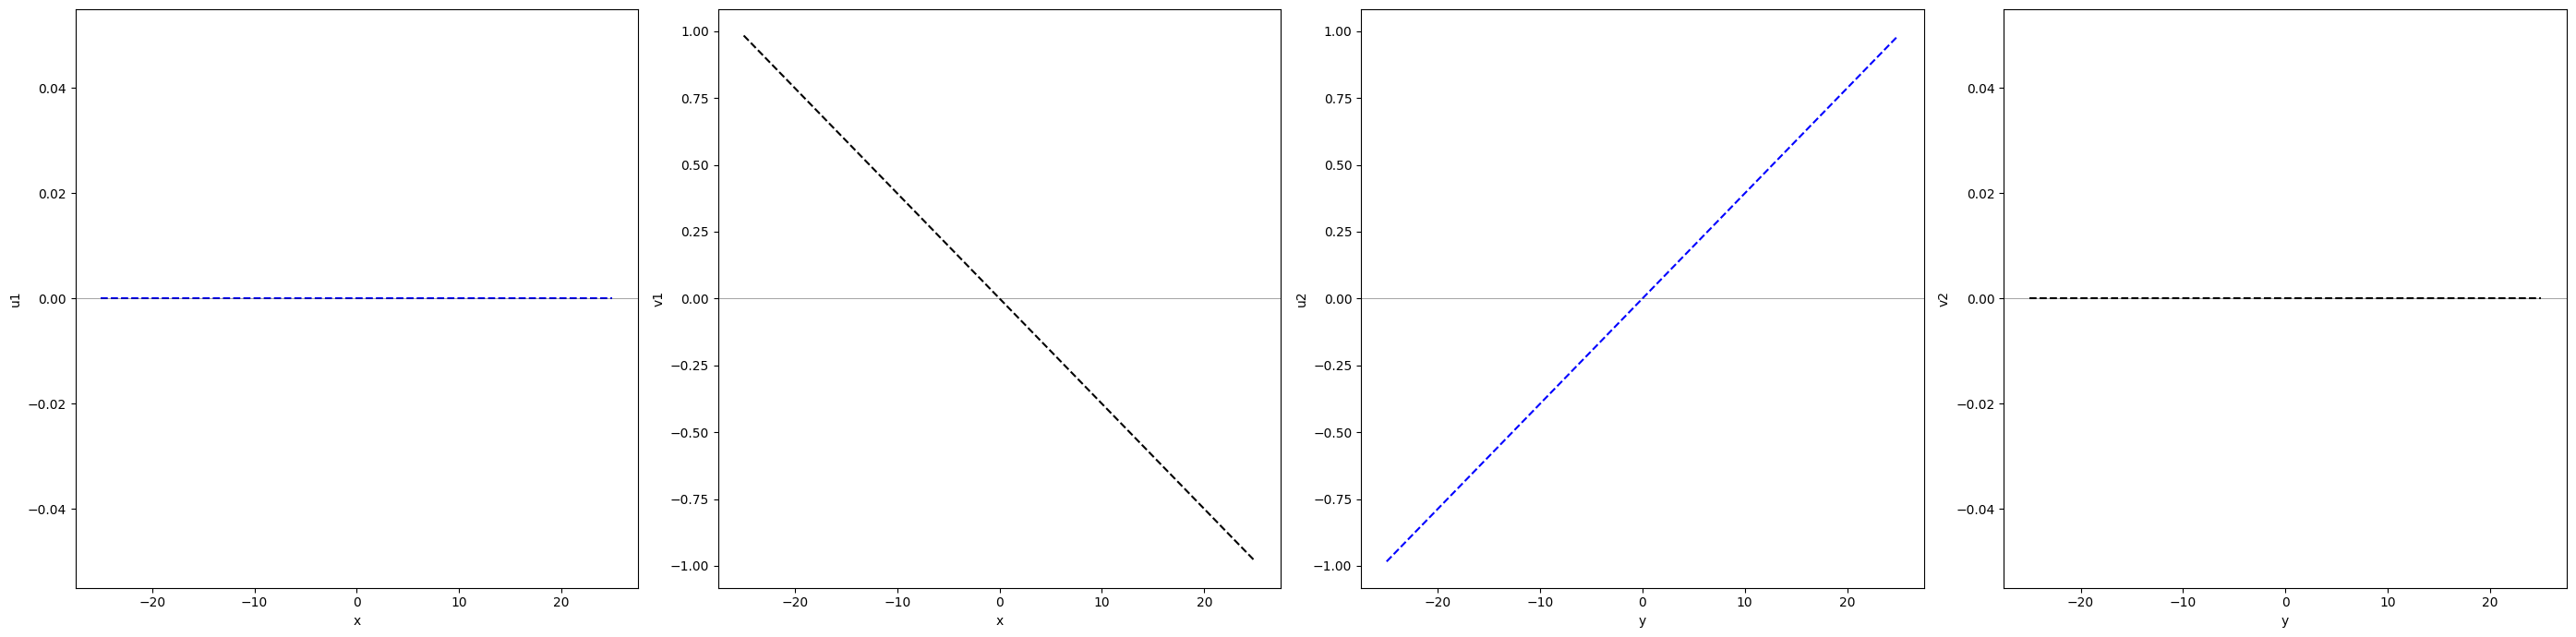

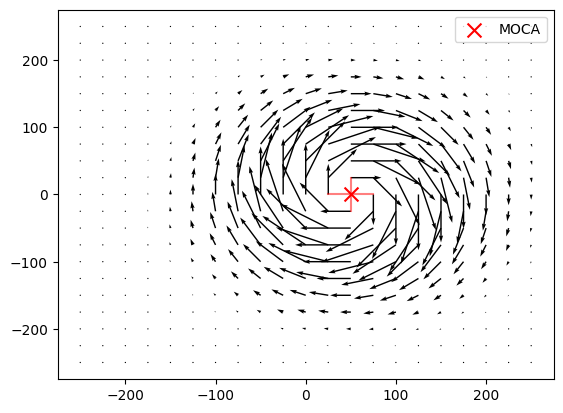

In [22]:
vis('Eddy2', 10)

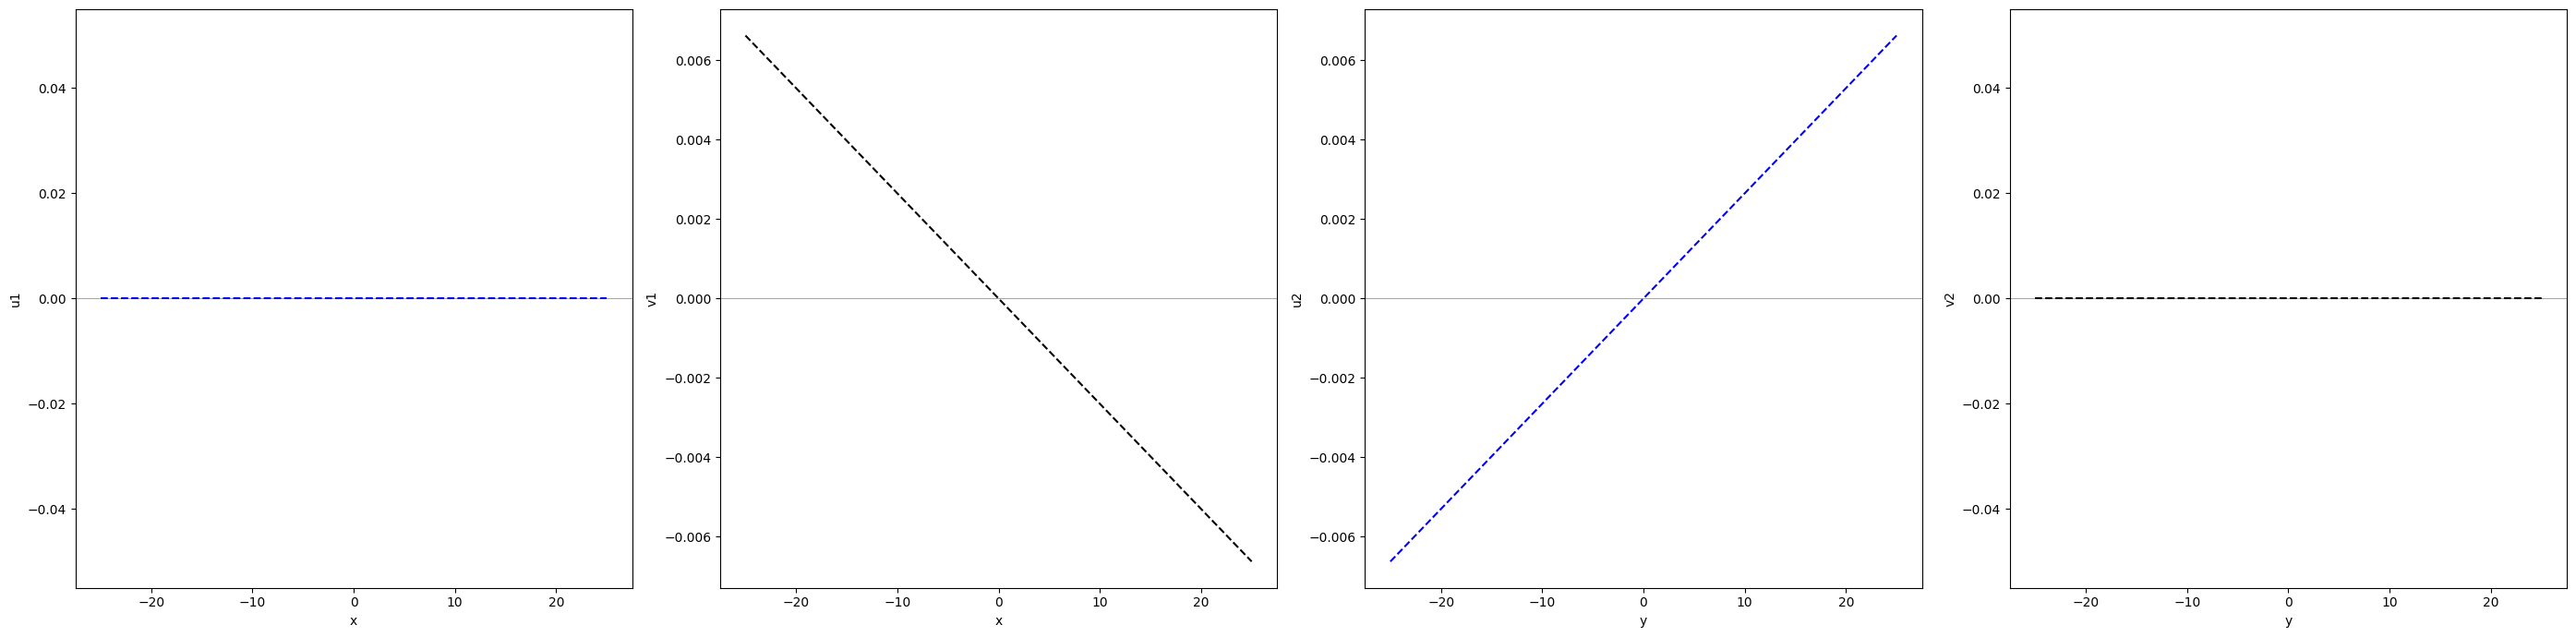

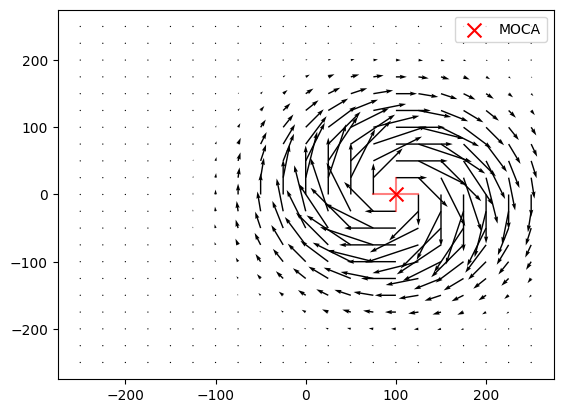

In [23]:
vis('Eddy3', 20)